# Der effektive Wert des erbschaftsteuerlichen Freibetrags – Entwicklung einer Referenzgröße als Basis für normative Diskussionen

Python-Code zu der Veröffentlichung von Diller/Kittl/Lorenz in Steuer und Wirtschaft (StuW), 2021

Hinweis: Zuerst R Code ausführen (Extrapolation in hohe Alter)

<h2>Notwendige Pakete importieren</h2>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Ggf. Working Directory festlegen

In [2]:
os.chdir('/Users/johannes/GitHub/Effective_Inheritance_Tax_Allowance')

In [3]:
os.listdir('2_temp_files')

['Frauen_West.csv',
 'Frauen_Ost.csv',
 'Männer_West.csv',
 'Männer_Ost.csv',
 'Männer.csv',
 'Frauen.csv']

<h2>Daten einlesen</h2>

In [5]:
#read original data
death_prob_male_df = pd.read_excel(os.path.join('0_data', 'periodensterbetafeln-bundeslaender-5126204207005.xlsx'), sheet_name='Deutschland männlich', skiprows=14, nrows=98, usecols='A,D')
death_prob_male_df.columns = ['Alter', 'Sterbewahrscheinlichkeit_male']
death_prob_female_df = pd.read_excel(os.path.join('0_data', 'periodensterbetafeln-bundeslaender-5126204207005.xlsx'), sheet_name='Deutschland weiblich', skiprows=14, nrows=97, usecols='A,D')
death_prob_female_df.columns = ['Alter', 'Sterbewahrscheinlichkeit_female']

#read estimated data for high ages
extended_male_df = pd.read_csv(os.path.join('2_temp_files', 'Männer.csv'), sep=',')
extended_male_df = extended_male_df.rename({'Unnamed: 0': 'Alter', 'x': 'Sterbewahrscheinlichkeit_male'}, axis=1)
extended_female_df = pd.read_csv(os.path.join('2_temp_files', 'Frauen.csv'), sep=',')
extended_female_df = extended_female_df.rename({'Unnamed: 0': 'Alter', 'x': 'Sterbewahrscheinlichkeit_female'}, axis=1)

# append higher ages
appended_male_df = pd.concat([death_prob_male_df, extended_male_df], ignore_index=True)
appended_female_df = pd.concat([death_prob_female_df, extended_female_df], ignore_index=True)

appended_male_df['Ueberlebenswahrscheinlichkeit_male'] = 1 - appended_male_df.Sterbewahrscheinlichkeit_male
appended_female_df['Ueberlebenswahrscheinlichkeit_female'] = 1 - appended_female_df.Sterbewahrscheinlichkeit_female

#everything in one dataframe
death_prob_df = pd.merge(appended_male_df, appended_female_df, how='left')

In [6]:
appended_female_df

,Alter,Sterbewahrscheinlichkeit_female,Ueberlebenswahrscheinlichkeit_female
0,0,0.002892,0.997108
1,1,0.000222,0.999778
2,2,0.000131,0.999869
3,3,0.000100,0.999900
4,4,0.000092,0.999908
...,...,...,...
108,108,0.805129,0.194871
109,109,0.832060,0.167940
110,110,0.856096,0.143904
111,111,0.877367,0.122633


<h2>Wahrscheinlichkeit für eine Person des Alters A, innerhalb der nächsten t Jahre zu versterben</h2>

Für das Modell wird die Sterbewahrscheinlichkeit im „letzten“ Jahr auf 1 gesetzt, sodass insgesamt eine Wahrscheinlichkeitsverteilung resultiert (mit Fläche unter der Dichtefunktion = 1).

### Männer

In [7]:
def death_prob_male(Alter, period):
    if Alter < 0:
        return 'Alter darf nicht negativ sein'
    elif Alter > 112:
        return 'Alter darf nicht über 112 sein'
    elif Alter + period > 112:
        return 'Person kann nicht so alt werden'
    elif ((Alter != 112) & (period == 0)):
        return death_prob_df.Sterbewahrscheinlichkeit_male[Alter]
    else:
        if (Alter + period == 112):# Gebe "Restwahrscheinlichkeit" aus sodass die Wahrscheinlichkeitsmasse insgesamt 1 ist
            tmp_var = 0
            for t in range(0, 112 - Alter):
                live_inner = np.prod(death_prob_df.Ueberlebenswahrscheinlichkeit_male[Alter:Alter + t])
                death_inner = death_prob_df.Sterbewahrscheinlichkeit_male[Alter + t]
                tmp_var = tmp_var + live_inner * death_inner
            return 1 - tmp_var
        else:# Gebe tatsächliche Wahrscheinlichkeit aus
            live = np.prod(death_prob_df.Ueberlebenswahrscheinlichkeit_male[Alter:Alter + period])
            death = death_prob_df.Sterbewahrscheinlichkeit_male[Alter + period]
            return live * death

### Frauen

In [8]:
def death_prob_female(Alter, period):
    if Alter < 0:
        return 'Alter darf nicht negativ sein'
    elif Alter > 112:
        return 'Alter darf nicht über 112 sein'
    elif Alter + period > 112:
        return 'Person kann nicht so alt werden'
    elif ((Alter != 112) & (period == 0)):
        return death_prob_df.Sterbewahrscheinlichkeit_female[Alter]
    else:
        if (Alter + period == 112):# Gebe "Restwahrscheinlichkeit" aus sodass die Wahrscheinlichkeitsmasse insgesamt 1 ist
            tmp_var = 0
            for t in range(0, 112 - Alter):
                live_inner = np.prod(death_prob_df.Ueberlebenswahrscheinlichkeit_female[Alter:Alter + t])
                death_inner = death_prob_df.Sterbewahrscheinlichkeit_female[Alter + t]
                tmp_var = tmp_var + live_inner * death_inner
            return 1 - tmp_var
        else:# Gebe tatsächliche Wahrscheinlichkeit aus
            live = np.prod(death_prob_df.Ueberlebenswahrscheinlichkeit_female[Alter:Alter + period])
            death = death_prob_df.Sterbewahrscheinlichkeit_female[Alter + period]
            return live * death

In [9]:
death_prob_female(112,0)

1

## Barwert des Erbst. Freibetrags

### Ohne Vermögenswachstum / Abzinsen

Männer

In [10]:
def present_value_male_prelim(Alter, BlockingPeriod):
    pv = 0
    for iterator in range(0,112 - Alter + 1):
        pv = pv + ( np.floor( iterator / BlockingPeriod) + 1 ) * 1 * death_prob_male(Alter, iterator)
    return pv 

Frauen

In [11]:
def present_value_female_prelim(Alter, BlockingPeriod):
    pv = 0
    for iterator in range(0,112 - Alter + 1):
        pv = pv + ( np.floor( iterator / BlockingPeriod) + 1 ) * 1 * death_prob_female(Alter, iterator)
    return pv 

In [12]:
present_value_male_prelim(50,10) * 400000

1413946.4937115433

In [13]:
present_value_female_prelim(50,10)

3.947388842917119

### Mit Vermögenswachstum und Abzinsen

Männer

In [14]:
def present_value_male(Alter, BlockingPeriod, Freibetrag, zins, rendite):
    part_a = 0
    part_b = 0
    part_c = 0
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod)) ):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_male(Alter, t + BlockingPeriod * z)) / ( (1 + zins) ** (t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter) / BlockingPeriod)) ):
        for l in range(z, int(np.floor((112 - Alter) / BlockingPeriod)) ):
            for t in range(0, BlockingPeriod ):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_male(Alter, t + BlockingPeriod * l)) / ( (1 + zins) ** (t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod)) + 1 ):
        for t in range(0, np.mod(112 - Alter, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_male(Alter, t + BlockingPeriod * int(np.floor((112 - Alter)/BlockingPeriod)))) / ( (1 + zins) ** (t + BlockingPeriod * int(np.floor((112 - Alter) / BlockingPeriod))) )

    return part_a + part_b + part_c

In [24]:
for i in range (40, 85, 5):
    print (np.round(present_value_delay_female(i,10,400000,0,0.052,0) - present_value_delay_female(i,10,400000,0,0.052,10),0))

4122950.0
3207479.0
2497492.0
1946347.0
1518017.0
1181789.0
910169.0
671818.0
438616.0


Frauen

In [16]:
def present_value_female(Alter, BlockingPeriod, Freibetrag, zins, rendite):
    part_a = 0
    part_b = 0
    part_c = 0
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod))):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_female(Alter, t + BlockingPeriod * z)) / ( (1 + zins) ** (t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter) / BlockingPeriod))):
        for l in range(z, int(np.floor((112 - Alter) / BlockingPeriod))):
            for t in range(0, BlockingPeriod):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_female(Alter, t + BlockingPeriod * l)) / ( (1 + zins) ** (t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod)) + 1):
        for t in range(0, np.mod(112 - Alter, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_female(Alter, t + BlockingPeriod * int(np.floor((112 - Alter)/BlockingPeriod)))) / ( (1 + zins) ** (t + BlockingPeriod * int(np.floor((112 - Alter) / BlockingPeriod))) )

    return part_a + part_b + part_c

In [18]:
present_value_female(50,10,400000,0,0.074)

10426691.562111571

In [19]:
present_value_female(50,10,400000,0,0.035) - present_value_male(50,10,400000,0,0.035)

579344.1420968799

## Barwert des erbst. Freibetrags bei Abwarten

Männer

In [20]:
def present_value_delay_male(Alter, BlockingPeriod, Freibetrag, zins, rendite, m):
    part_d = 0
    part_a = 0
    part_b = 0
    part_c = 0
    
    for t in range(0, m):
        part_d = part_d + Freibetrag * death_prob_male(Alter, t) / ((1 + zins) ** t)
    
    for z in range(0, int(np.floor((112 - Alter - m) / BlockingPeriod))):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_male(Alter, m + t + BlockingPeriod * z)) / ( (1 + zins) ** (m + t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter - m) / BlockingPeriod))):
        for l in range(z, int(np.floor((112 - Alter - m) / BlockingPeriod))):
            for t in range(0, BlockingPeriod):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_male(Alter, m + t + BlockingPeriod * l)) / ( (1 + zins) ** (m + t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter - m) / BlockingPeriod)) + 1):
        for t in range(0, np.mod(112 - Alter - m, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_male(Alter, m + t + BlockingPeriod * int(np.floor((112 - Alter - m) / BlockingPeriod)))) / ( (1 + zins) ** (m + t + BlockingPeriod * int(np.floor((112 - Alter - m) / BlockingPeriod))) )

    return part_a + part_b + part_c + part_d

In [21]:
present_value_delay_male(50,10,400000,0,0.035,5)

2311471.9383401386

Frauen

In [22]:
def present_value_delay_female(Alter, BlockingPeriod, Freibetrag, zins, rendite, m):
    part_d = 0
    part_a = 0
    part_b = 0
    part_c = 0
    
    for t in range(0, m):
        part_d = part_d + Freibetrag * death_prob_female(Alter, t) / ((1 + zins) ** t)
    
    for z in range(0, int(np.floor((112 - Alter - m) / BlockingPeriod))):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_female(Alter, m + t + BlockingPeriod * z)) / ( (1 + zins) ** (m + t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter - m) / BlockingPeriod))):
        for l in range(z, int(np.floor((112 - Alter - m) / BlockingPeriod))):
            for t in range(0, BlockingPeriod):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_female(Alter, m + t + BlockingPeriod * l)) / ( (1 + zins) ** (m + t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter - m) / BlockingPeriod)) + 1):
        for t in range(0, np.mod(112 - Alter - m, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_female(Alter, m + t + BlockingPeriod * int(np.floor((112 - Alter - m) / BlockingPeriod)))) / ( (1 + zins) ** (m + t + BlockingPeriod * int(np.floor((112 - Alter - m) / BlockingPeriod))) )

    return part_a + part_b + part_c + part_d

In [25]:
present_value_delay_female(50,10,400000,0,0.035,5)

2796790.8658116814

### Abbildung 2

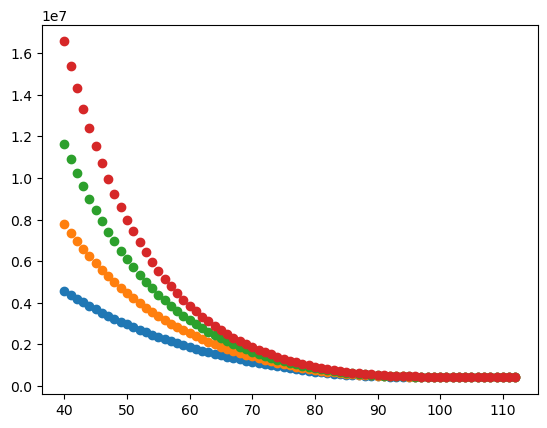

In [26]:
x = []
for alter in range(40, 113):
    x.append(alter)
y1 = []
for alter in x:
    y1.append(present_value_male(alter, 10, 400000, 0, 0.035))
y2 = []
for alter in x:
    y2.append(present_value_male(alter, 10, 400000, 0, 0.052))
y3 = []
for alter in x:
    y3.append(present_value_male(alter, 10, 400000, 0, 0.064))
y4 = []
for alter in x:
    y4.append(present_value_male(alter, 10, 400000, 0, 0.074))
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)
plt.scatter(x, y4)
plt.show()

### Abbildung 7

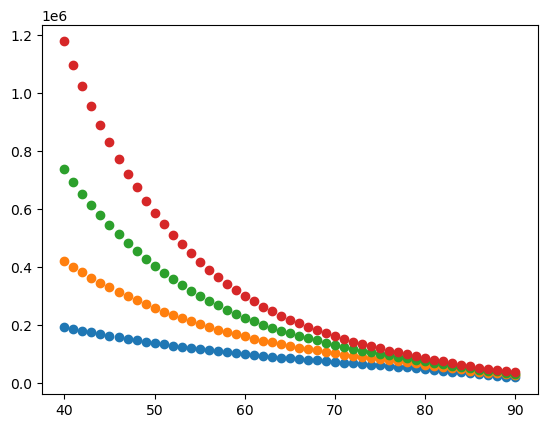

In [27]:
x = []
for alter in range(40, 91):
    x.append(alter)
y1 = []
for alter in x:
    y1.append(present_value_delay_male(alter, 10, 400000, 0, 0.035, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.035, 1))
y2 = []
for alter in x:
    y2.append(present_value_delay_male(alter, 10, 400000, 0, 0.052, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.052, 1))
y3 = []
for alter in x:
    y3.append(present_value_delay_male(alter, 10, 400000, 0, 0.064, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.064, 1))
y4 = []
for alter in x:
    y4.append(present_value_delay_male(alter, 10, 400000, 0, 0.074, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.074, 1))
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)
plt.scatter(x, y4)
plt.show()

### Abbildung 8

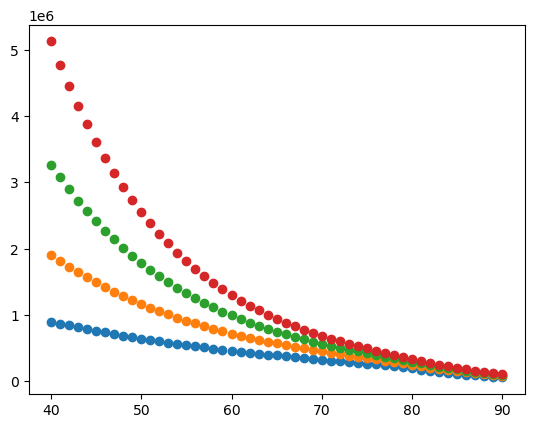

In [28]:
x = []
for alter in range(40, 91):
    x.append(alter)
y1 = []
for alter in x:
    y1.append(present_value_delay_male(alter, 10, 400000, 0, 0.035, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.035, 5))
y2 = []
for alter in x:
    y2.append(present_value_delay_male(alter, 10, 400000, 0, 0.052, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.052, 5))
y3 = []
for alter in x:
    y3.append(present_value_delay_male(alter, 10, 400000, 0, 0.064, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.064, 5))
y4 = []
for alter in x:
    y4.append(present_value_delay_male(alter, 10, 400000, 0, 0.074, 0) - present_value_delay_male(alter, 10, 400000, 0, 0.074, 5))
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)
plt.scatter(x, y4)
plt.show()

### Abbildung 9

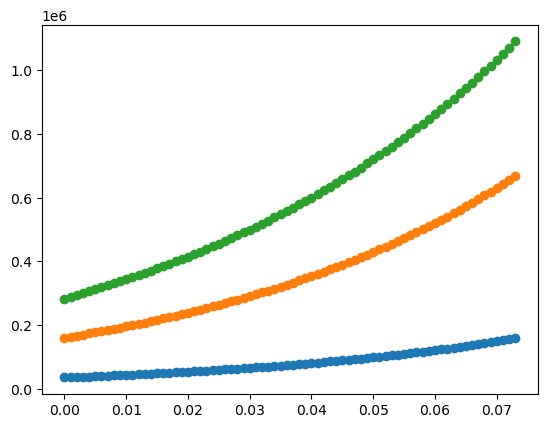

In [29]:
x = []
for wachstum in np.arange(0, 0.074, 0.001):
    x.append(wachstum)
y1 = []
for wachstum in x:
    y1.append(present_value_delay_male(70, 10, 400000, 0, wachstum, 0) - present_value_delay_male(70, 10, 400000, 0, wachstum, 1))
y2 = []
for wachstum in x:
    y2.append(present_value_delay_male(70, 10, 400000, 0, wachstum, 0) - present_value_delay_male(70, 10, 400000, 0, wachstum, 5))
y3 = []
for wachstum in x:
    y3.append(present_value_delay_male(70, 10, 400000, 0, wachstum, 0) - present_value_delay_male(70, 10, 400000, 0, wachstum, 10))
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)
plt.show()

## Tabellen für den Anhang

In [30]:
return_list = [0.035, 0.052, 0.064, 0.074]

### Werte für Männer

In [31]:
def costs_dep_return_men(r):
    costs_dict_men = {}
    for Alter in range(40, 85, 5):
        temp_list = []
        for m in [5, 10]:
            temp_list.append(present_value_delay_male(Alter, 10, 400000, 0, r, 0) - present_value_delay_male(Alter, 10, 400000, 0, r, m))
        costs_dict_men[Alter] = temp_list
    return costs_dict_men

In [32]:
#Falls die Excel-Datei schon existiert, vorher löschen
if 'costs_men_general.xlsx' in os.listdir('3_output'):
    os.remove(os.path.join('3_output', 'costs_men_general.xlsx'))

#Einzelne Excel-Arbeitsblätter für die Zinssätze erstellen
sheet_name = 'men_{}'.format(return_list[0])
with pd.ExcelWriter(os.path.join('3_output', 'costs_men_general.xlsx'), mode = 'w') as writer:
    costs_df = pd.DataFrame(data = costs_dep_return_men(return_list[0])).transpose()
    costs_df.columns=[5, 10]
    costs_df.round(2)
    costs_df.to_excel(writer, sheet_name = sheet_name)
for r in return_list:
    if r != return_list[0]:
        sheet_name = 'men_{}'.format(r)
        with pd.ExcelWriter(os.path.join('3_output', 'costs_men_general.xlsx'), mode = 'a') as writer:
            costs_df = pd.DataFrame(data = costs_dep_return_men(r)).transpose()
            costs_df.columns=[5, 10]
            costs_df.round(2)
            costs_df.to_excel(writer, sheet_name = sheet_name)

### Werte für Frauen

In [33]:
def costs_dep_return_women(r):
    costs_dict_women = {}
    for Alter in range(40, 85, 5):
        temp_list = []
        for m in [5, 10]:
            temp_list.append(present_value_delay_female(Alter, 10, 400000, 0, r, 0) - present_value_delay_female(Alter, 10, 400000, 0, r, m))
        costs_dict_women[Alter] = temp_list
    return costs_dict_women

In [34]:
#Falls die Excel-Datei schon existiert, vorher löschen
if 'costs_women_general.xlsx' in os.listdir('3_output'):
    os.remove(os.path.join('3_output', 'costs_women_general.xlsx'))

#Einzelne Excel-Arbeitsblätter für die Zinssätze erstellen
sheet_name = 'women_{}'.format(return_list[0])
with pd.ExcelWriter(os.path.join('3_output', 'costs_women_general.xlsx'), mode = 'w') as writer:
    costs_df = pd.DataFrame(data = costs_dep_return_women(return_list[0])).transpose()
    costs_df.columns=[5, 10]
    costs_df.round(2)
    costs_df.to_excel(writer, sheet_name = sheet_name)
for r in return_list:
    if r != return_list[0]:
        sheet_name = 'women_{}'.format(r)
        with pd.ExcelWriter(os.path.join('3_output', 'costs_women_general.xlsx'), mode = 'a') as writer:
            costs_df = pd.DataFrame(data = costs_dep_return_women(r)).transpose()
            costs_df.columns=[5, 10]
            costs_df.round(2)
            costs_df.to_excel(writer, sheet_name = sheet_name)

In [35]:
present_value_male(50, 10, 400000, 0, 0.05)

4242212.837669447

#Tabellen für den Anhang (mit variabler Blocking Period)

In [36]:
return_list = [0.035, 0.052, 0.064, 0.074]

In [37]:
def effective_allowance_men(r):
    costs_dict_men = {}
    for Alter in range(40, 85, 5):
        temp_list = []
        for m in [10, 20]:
            temp_list.append(present_value_delay_male(Alter, m, 400000, 0, r, 0))
        costs_dict_men[Alter] = temp_list
    return costs_dict_men

In [38]:
#Falls die Excel-Datei schon existiert, vorher löschen
if 'effective_allowance_men.xlsx' in os.listdir('3_output'):
    os.remove(os.path.join('3_output', 'effective_allowance_men.xlsx'))

#Einzelne Excel-Arbeitsblätter für die Zinssätze erstellen
sheet_name = 'men_{}'.format(return_list[0])
with pd.ExcelWriter(os.path.join('3_output', 'effective_allowance_men.xlsx'), mode = 'w') as writer:
    costs_df = pd.DataFrame(data = effective_allowance_men(return_list[0])).transpose()
    costs_df.columns=[10, 20]
    costs_df.round(2)
    costs_df.to_excel(writer, sheet_name = sheet_name)
for r in return_list:
    if r != return_list[0]:
        sheet_name = 'men_{}'.format(r)
        with pd.ExcelWriter(os.path.join('3_output', 'effective_allowance_men.xlsx'), mode = 'a') as writer:
            costs_df = pd.DataFrame(data = effective_allowance_men(r)).transpose()
            costs_df.columns=[10, 20]
            costs_df.round(2)
            costs_df.to_excel(writer, sheet_name = sheet_name)

In [39]:
def effective_allowance_women(r):
    costs_dict_women = {}
    for Alter in range(40, 85, 5):
        temp_list = []
        for m in [10, 20]:
            temp_list.append(present_value_delay_female(Alter, m, 400000, 0, r, 0))
        costs_dict_women[Alter] = temp_list
    return costs_dict_women

In [40]:
#Falls die Excel-Datei schon existiert, vorher löschen
if 'effective_allowance_women.xlsx' in os.listdir('3_output'):
    os.remove(os.path.join('3_output', 'effective_allowance_women.xlsx'))

#Einzelne Excel-Arbeitsblätter für die Zinssätze erstellen
sheet_name = 'women_{}'.format(return_list[0])
with pd.ExcelWriter(os.path.join('3_output', 'effective_allowance_women.xlsx'), mode = 'w') as writer:
    costs_df = pd.DataFrame(data = effective_allowance_women(return_list[0])).transpose()
    costs_df.columns=[10, 20]
    costs_df.round(2)
    costs_df.to_excel(writer, sheet_name = sheet_name)
for r in return_list:
    if r != return_list[0]:
        sheet_name = 'women_{}'.format(r)
        with pd.ExcelWriter(os.path.join('3_output', 'effective_allowance_women.xlsx'), mode = 'a') as writer:
            costs_df = pd.DataFrame(data = effective_allowance_women(r)).transpose()
            costs_df.columns=[10, 20]
            costs_df.round(2)
            costs_df.to_excel(writer, sheet_name = sheet_name)

## Einfluss der Sperrfrist (Abbildung 6)

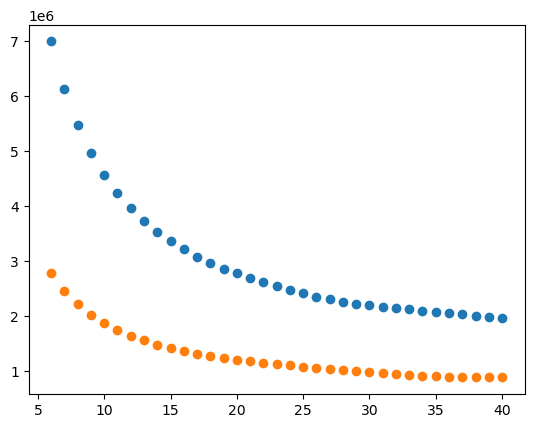

In [41]:
x = []
for i in range(5, 40):
    x.append(i + 1)
y1 = []
for i in x:
    y1.append(present_value_male(40, i, 400000, 0, 0.035))
y2 = []
for i in x:
    y2.append(present_value_male(60, i, 400000, 0, 0.035))
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.show()

### Vorteil für Frauen in Abhängigkeit von der Sperrfrist

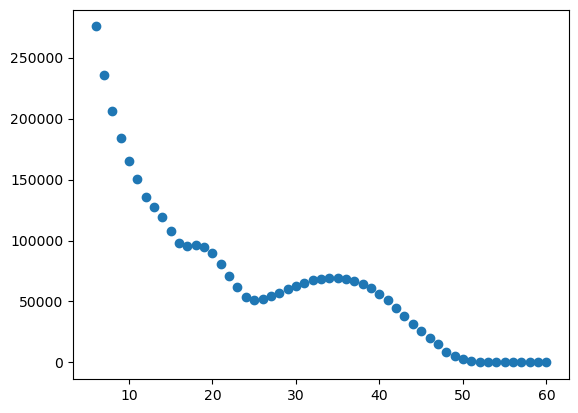

In [42]:
x = []
for i in range(5, 60):
    x.append(i + 1)
y = []
for i in x:
    y.append(present_value_female(50, i, 400000, 0, 0) - present_value_male(50, i, 400000, 0, 0))
plt.scatter(x, y)
plt.show()

# Vorteil für Bewohner der alten Bundesländer

## Daten einlesen

In [44]:
#read original data
#west
death_prob_west_male_df = pd.read_excel(os.path.join('0_data', 'periodensterbetafeln-bundeslaender-5126204207005.xlsx'), sheet_name='Westdeutschland männlich', skiprows=14, nrows=98, usecols='A,D')
death_prob_west_male_df.columns = ['Alter', 'Sterbewahrscheinlichkeit_wessi_male']
death_prob_west_female_df = pd.read_excel(os.path.join('0_data', 'periodensterbetafeln-bundeslaender-5126204207005.xlsx'), sheet_name='Westdeutschland weiblich', skiprows=14, nrows=97, usecols='A,D')
death_prob_west_female_df.columns = ['Alter', 'Sterbewahrscheinlichkeit_wessi_female']
#ost
death_prob_ost_male_df = pd.read_excel(os.path.join('0_data', 'periodensterbetafeln-bundeslaender-5126204207005.xlsx'), sheet_name='Ostdeutschland männlich', skiprows=14, nrows=98, usecols='A,D')
death_prob_ost_male_df.columns = ['Alter', 'Sterbewahrscheinlichkeit_ossi_male']
death_prob_ost_female_df = pd.read_excel(os.path.join('0_data', 'periodensterbetafeln-bundeslaender-5126204207005.xlsx'), sheet_name='Ostdeutschland weiblich', skiprows=14, nrows=97, usecols='A,D')
death_prob_ost_female_df.columns = ['Alter', 'Sterbewahrscheinlichkeit_ossi_female']

#read estimated data for high ages
#west
extended_west_male_df = pd.read_csv(os.path.join('2_temp_files', 'Männer_West.csv'), sep=',')
extended_west_male_df = extended_west_male_df.rename({'Unnamed: 0': 'Alter', 'x': 'Sterbewahrscheinlichkeit_wessi_male'}, axis=1)
extended_west_female_df = pd.read_csv(os.path.join('2_temp_files', 'Frauen_West.csv'), sep=',')
extended_west_female_df = extended_west_female_df.rename({'Unnamed: 0': 'Alter', 'x': 'Sterbewahrscheinlichkeit_wessi_female'}, axis=1)
#ost
extended_ost_male_df = pd.read_csv(os.path.join('2_temp_files', 'Männer_Ost.csv'), sep=',')
extended_ost_male_df = extended_ost_male_df.rename({'Unnamed: 0': 'Alter', 'x': 'Sterbewahrscheinlichkeit_ossi_male'}, axis=1)
extended_ost_female_df = pd.read_csv(os.path.join('2_temp_files', 'Frauen_Ost.csv'), sep=',')
extended_ost_female_df = extended_ost_female_df.rename({'Unnamed: 0': 'Alter', 'x': 'Sterbewahrscheinlichkeit_ossi_female'}, axis=1)

# append higher ages
# west
appended_west_male_df = pd.concat([death_prob_west_male_df, extended_west_male_df], ignore_index=True)
appended_west_female_df = pd.concat([death_prob_west_female_df, extended_west_female_df], ignore_index=True)

# ost
appended_ost_male_df = pd.concat([death_prob_ost_male_df, extended_ost_male_df], ignore_index=True)
appended_ost_female_df = pd.concat([death_prob_ost_female_df, extended_ost_female_df], ignore_index=True)


#calculate survival probabilities
#west
appended_west_male_df['Ueberlebenswahrscheinlichkeit_wessi_male'] = 1 - appended_west_male_df.Sterbewahrscheinlichkeit_wessi_male
appended_west_female_df['Ueberlebenswahrscheinlichkeit_wessi_female'] = 1 - appended_west_female_df.Sterbewahrscheinlichkeit_wessi_female
#ost
appended_ost_male_df['Ueberlebenswahrscheinlichkeit_ossi_male'] = 1 - appended_ost_male_df.Sterbewahrscheinlichkeit_ossi_male
appended_ost_female_df['Ueberlebenswahrscheinlichkeit_ossi_female'] = 1 - appended_ost_female_df.Sterbewahrscheinlichkeit_ossi_female

#everything in one dataframe
temp1_df = pd.merge(appended_west_male_df, appended_west_female_df, how='left')
temp2_df = pd.merge(appended_ost_male_df, appended_ost_female_df, how='left')
death_prob_ow_df = pd.merge(temp1_df, temp2_df, how='left')

In [45]:
death_prob_ow_df.head()

,Alter,Sterbewahrscheinlichkeit_wessi_male,Ueberlebenswahrscheinlichkeit_wessi_male,Sterbewahrscheinlichkeit_wessi_female,Ueberlebenswahrscheinlichkeit_wessi_female,Sterbewahrscheinlichkeit_ossi_male,Ueberlebenswahrscheinlichkeit_ossi_male,Sterbewahrscheinlichkeit_ossi_female,Ueberlebenswahrscheinlichkeit_ossi_female
0,0,0.003454,0.996546,0.002998,0.997002,0.002870,0.997130,0.002303,0.997697
1,1,0.000225,0.999775,0.000216,0.999784,0.000366,0.999634,0.000243,0.999757
2,2,0.000129,0.999871,0.000128,0.999872,0.000160,0.999840,0.000180,0.999820
3,3,0.000114,0.999886,0.000102,0.999898,0.000140,0.999860,0.000092,0.999908
4,4,0.000114,0.999886,0.000101,0.999899,0.000128,0.999872,0.000061,0.999939


In [46]:
def death_prob_wessi_male(Alter, period):
    if Alter < 0:
        return 'Alter darf nicht negativ sein'
    elif Alter > 112:
        return 'Alter darf nicht über 112 sein'
    elif Alter + period > 112:
        return 'Person kann nicht so alt werden'
    elif ((Alter != 112) & (period == 0)):
        return death_prob_ow_df.Sterbewahrscheinlichkeit_wessi_male[Alter]
    else:
        if (Alter + period == 112):# Gebe "Restwahrscheinlichkeit" aus sodass die Wahrscheinlichkeitsmasse insgesamt 1 ist
            tmp_var = 0
            for t in range(0, 112 - Alter):
                live_inner = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_wessi_male[Alter:Alter + t])
                death_inner = death_prob_ow_df.Sterbewahrscheinlichkeit_wessi_male[Alter + t]
                tmp_var = tmp_var + live_inner * death_inner
            return 1 - tmp_var
        else:# Gebe tatsächliche Wahrscheinlichkeit aus
            live = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_wessi_male[Alter:Alter + period])
            death = death_prob_ow_df.Sterbewahrscheinlichkeit_wessi_male[Alter + period]
            return live * death

def death_prob_ossi_male(Alter, period):
    if Alter < 0:
        return 'Alter darf nicht negativ sein'
    elif Alter > 112:
        return 'Alter darf nicht über 112 sein'
    elif Alter + period > 112:
        return 'Person kann nicht so alt werden'
    elif ((Alter != 112) & (period == 0)):
        return death_prob_ow_df.Sterbewahrscheinlichkeit_ossi_male[Alter]
    else:
        if (Alter + period == 112):# Gebe "Restwahrscheinlichkeit" aus sodass die Wahrscheinlichkeitsmasse insgesamt 1 ist
            tmp_var = 0
            for t in range(0, 112 - Alter):
                live_inner = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_ossi_male[Alter:Alter + t])
                death_inner = death_prob_ow_df.Sterbewahrscheinlichkeit_ossi_male[Alter + t]
                tmp_var = tmp_var + live_inner * death_inner
            return 1 - tmp_var
        else:# Gebe tatsächliche Wahrscheinlichkeit aus
            live = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_ossi_male[Alter:Alter + period])
            death = death_prob_ow_df.Sterbewahrscheinlichkeit_ossi_male[Alter + period]
            return live * death

def death_prob_wessi_female(Alter, period):
    if Alter < 0:
        return 'Alter darf nicht negativ sein'
    elif Alter > 112:
        return 'Alter darf nicht über 112 sein'
    elif Alter + period > 112:
        return 'Person kann nicht so alt werden'
    elif ((Alter != 112) & (period == 0)):
        return death_prob_ow_df.Sterbewahrscheinlichkeit_wessi_female[Alter]
    else:
        if (Alter + period == 112):# Gebe "Restwahrscheinlichkeit" aus sodass die Wahrscheinlichkeitsmasse insgesamt 1 ist
            tmp_var = 0
            for t in range(0, 112 - Alter):
                live_inner = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_wessi_female[Alter:Alter + t])
                death_inner = death_prob_ow_df.Sterbewahrscheinlichkeit_wessi_female[Alter + t]
                tmp_var = tmp_var + live_inner * death_inner
            return 1 - tmp_var
        else:# Gebe tatsächliche Wahrscheinlichkeit aus
            live = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_wessi_female[Alter:Alter + period])
            death = death_prob_ow_df.Sterbewahrscheinlichkeit_wessi_female[Alter + period]
            return live * death

def death_prob_ossi_female(Alter, period):
    if Alter < 0:
        return 'Alter darf nicht negativ sein'
    elif Alter > 112:
        return 'Alter darf nicht über 112 sein'
    elif Alter + period > 112:
        return 'Person kann nicht so alt werden'
    elif ((Alter != 112) & (period == 0)):
        return death_prob_ow_df.Sterbewahrscheinlichkeit_ossi_female[Alter]
    else:
        if (Alter + period == 112):# Gebe "Restwahrscheinlichkeit" aus sodass die Wahrscheinlichkeitsmasse insgesamt 1 ist
            tmp_var = 0
            for t in range(0, 112 - Alter):
                live_inner = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_ossi_female[Alter:Alter + t])
                death_inner = death_prob_ow_df.Sterbewahrscheinlichkeit_ossi_female[Alter + t]
                tmp_var = tmp_var + live_inner * death_inner
            return 1 - tmp_var
        else:# Gebe tatsächliche Wahrscheinlichkeit aus
            live = np.prod(death_prob_ow_df.Ueberlebenswahrscheinlichkeit_ossi_female[Alter:Alter + period])
            death = death_prob_ow_df.Sterbewahrscheinlichkeit_ossi_female[Alter + period]
            return live * death

In [47]:
def present_value_wessi_male(Alter, BlockingPeriod, Freibetrag, zins, rendite):
    part_a = 0
    part_b = 0
    part_c = 0
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod))):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_wessi_male(Alter, t + BlockingPeriod * z)) / ( (1 + zins) ** (t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter) / BlockingPeriod))):
        for l in range(z, int(np.floor((112 - Alter) / BlockingPeriod))):
            for t in range(0, BlockingPeriod):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_wessi_male(Alter, t + BlockingPeriod * l)) / ( (1 + zins) ** (t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod)) + 1):
        for t in range(0, np.mod(112 - Alter, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_wessi_male(Alter, t + BlockingPeriod * int(np.floor((112 - Alter)/BlockingPeriod)))) / ( (1 + zins) ** (t + BlockingPeriod * int(np.floor((112 - Alter) / BlockingPeriod))) )

    return part_a + part_b + part_c

def present_value_ossi_male(Alter, BlockingPeriod, Freibetrag, zins, rendite):
    part_a = 0
    part_b = 0
    part_c = 0
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod))):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_ossi_male(Alter, t + BlockingPeriod * z)) / ( (1 + zins) ** (t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter) / BlockingPeriod))):
        for l in range(z, int(np.floor((112 - Alter) / BlockingPeriod))):
            for t in range(0, BlockingPeriod):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_ossi_male(Alter, t + BlockingPeriod * l)) / ( (1 + zins) ** (t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod)) + 1):
        for t in range(0, np.mod(112 - Alter, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_ossi_male(Alter, t + BlockingPeriod * int(np.floor((112 - Alter)/BlockingPeriod)))) / ( (1 + zins) ** (t + BlockingPeriod * int(np.floor((112 - Alter) / BlockingPeriod))) )

    return part_a + part_b + part_c

def present_value_wessi_female(Alter, BlockingPeriod, Freibetrag, zins, rendite):
    part_a = 0
    part_b = 0
    part_c = 0
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod))):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_wessi_female(Alter, t + BlockingPeriod * z)) / ( (1 + zins) ** (t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter) / BlockingPeriod))):
        for l in range(z, int(np.floor((112 - Alter) / BlockingPeriod))):
            for t in range(0, BlockingPeriod):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_wessi_female(Alter, t + BlockingPeriod * l)) / ( (1 + zins) ** (t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod)) + 1):
        for t in range(0, np.mod(112 - Alter, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_wessi_female(Alter, t + BlockingPeriod * int(np.floor((112 - Alter)/BlockingPeriod)))) / ( (1 + zins) ** (t + BlockingPeriod * int(np.floor((112 - Alter) / BlockingPeriod))) )

    return part_a + part_b + part_c

def present_value_ossi_female(Alter, BlockingPeriod, Freibetrag, zins, rendite):
    part_a = 0
    part_b = 0
    part_c = 0
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod))):
        for t in range(0, BlockingPeriod):
            part_a = part_a + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_ossi_female(Alter, t + BlockingPeriod * z)) / ( (1 + zins) ** (t + BlockingPeriod * z) )
    
    for z in range(1, int(np.floor((112 - Alter) / BlockingPeriod))):
        for l in range(z, int(np.floor((112 - Alter) / BlockingPeriod))):
            for t in range(0, BlockingPeriod):
                part_b = part_b + (Freibetrag * (1 + rendite) ** (BlockingPeriod * (l - z) + t) * death_prob_ossi_female(Alter, t + BlockingPeriod * l)) / ( (1 + zins) ** (t + BlockingPeriod * l) )
    
    for z in range(0, int(np.floor((112 - Alter) / BlockingPeriod)) + 1):
        for t in range(0, np.mod(112 - Alter, BlockingPeriod) + 1):
            part_c = part_c + (Freibetrag * (1 + rendite) ** (BlockingPeriod * z + t) * death_prob_ossi_female(Alter, t + BlockingPeriod * int(np.floor((112 - Alter)/BlockingPeriod)))) / ( (1 + zins) ** (t + BlockingPeriod * int(np.floor((112 - Alter) / BlockingPeriod))) )

    return part_a + part_b + part_c

### Vorteil westdeutsche Frauen

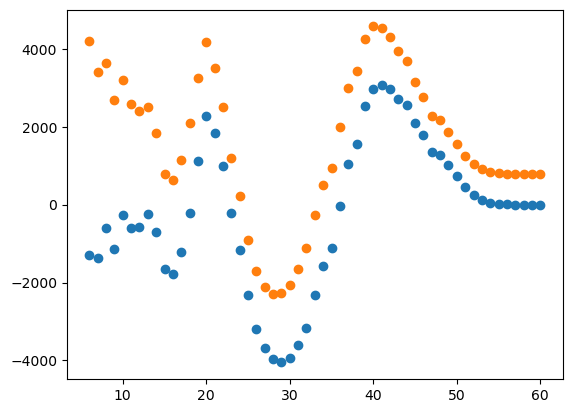

In [48]:
x = []
for i in range(5, 60):
    x.append(i + 1)
y = []
for i in x:
    y.append(present_value_wessi_female(50, i, 400000, 0, 0) - present_value_ossi_female(50, i, 400000, 0, 0) )
plt.scatter(x, y)
yzins = []
for i in x:
    yzins.append(present_value_wessi_female(50, i, 400000, 0, 0.035) - present_value_ossi_female(50, i, 400000, 0, 0.035) )
plt.scatter(x, yzins)
plt.show()

### Vorteil für westdeutsche Männer

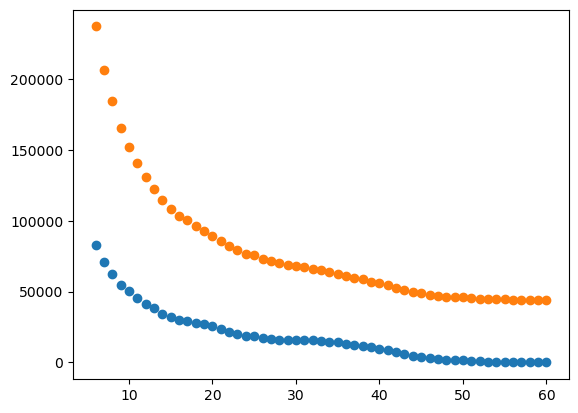

In [49]:
x = []
for i in range(5, 60):
    x.append(i + 1)
y = []
for i in x:
    y.append(present_value_wessi_male(50, i, 400000, 0, 0) - present_value_ossi_male(50, i, 400000, 0, 0))
plt.scatter(x, y)
yzins = []
for i in x:
    yzins.append(present_value_wessi_male(50, i, 400000, 0, 0.035) - present_value_ossi_male(50, i, 400000, 0, 0.035))
plt.scatter(x, yzins)
plt.show()

### Vorteil Frauen allgemein (ggü. Männern allgemein)

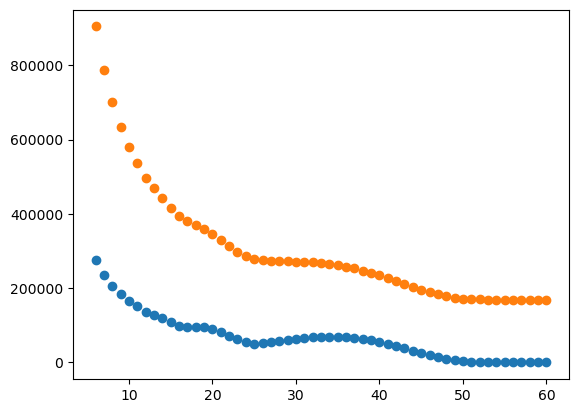

In [50]:
x = []
for i in range(5, 60):
    x.append(i + 1)
y = []
for i in x:
    y.append(present_value_female(50, i, 400000, 0, 0) - present_value_male(50, i, 400000, 0, 0))
plt.scatter(x, y)
yzins = []
for i in x:
    yzins.append(present_value_female(50, i, 400000, 0, 0.035) - present_value_male(50, i, 400000, 0, 0.035))
plt.scatter(x, yzins)
plt.show()

### Alles in einer Grafik (für TRR266-Report)

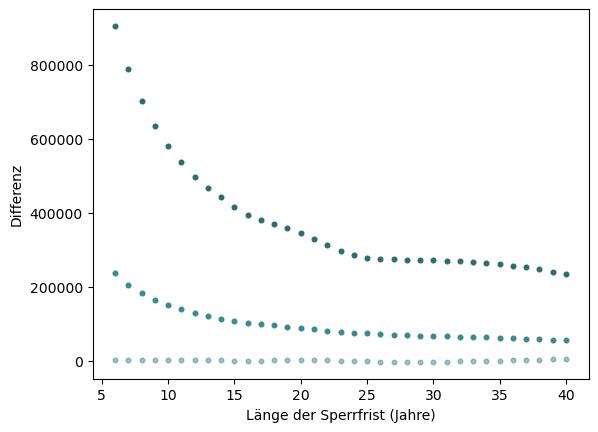

In [51]:
x = []
for i in range(5, 40):
    x.append(i + 1)
y = []
for i in x:
    y.append(present_value_female(50, i, 400000, 0, 0.035) - present_value_male(50, i, 400000, 0, 0.035))
plt.scatter(x, y, s=11, c=[[0.196, 0.42, 0.424, 1]])
z = []
for i in x:
    z.append(present_value_wessi_male(50, i, 400000, 0, 0.035) - present_value_ossi_male(50, i, 400000, 0, 0.035))
plt.scatter(x, z, s=11, c=[[0.25, 0.53, 0.56, 1]])
za = []
for i in x:
    za.append(present_value_wessi_female(50, i, 400000, 0, 0.035) - present_value_ossi_female(50, i, 400000, 0, 0.035))
plt.xlabel("Länge der Sperrfrist (Jahre)")
plt.ylabel("Differenz")
plt.scatter(x, za, s=11, c=[[0.25, 0.53, 0.56, 0.5]])
#plt.show()
plt.savefig(os.path.join('3_output', 'figure4.svg'), format = 'svg', dpi=300)

### Einfluss der Sperrfrist (für TRR266-Report)

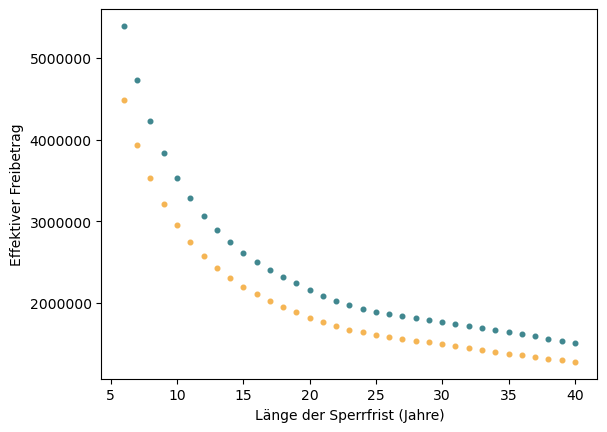

In [52]:
x = []
for i in range(5, 40):
    x.append(i + 1)
y50w = []
y50m = []
for i in x:
    y50m.append(present_value_male(50, i, 400000, 0, 0.035))
    y50w.append(present_value_female(50, i, 400000, 0, 0.035))
plt.xlabel("Länge der Sperrfrist (Jahre)")
plt.ylabel("Effektiver Freibetrag")
plt.scatter(x, y50w, s=11, c=[[0.25, 0.53, 0.56, 1]])
plt.scatter(x, y50m, s=11, c=[[0.96, 0.71, 0.33, 1]])
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
#plt.show()
plt.savefig(os.path.join('3_output', 'figure3.svg'), format = 'svg', dpi=300)

### Einfluss der Sperrfrist (für TRR266-Report, alternativ)

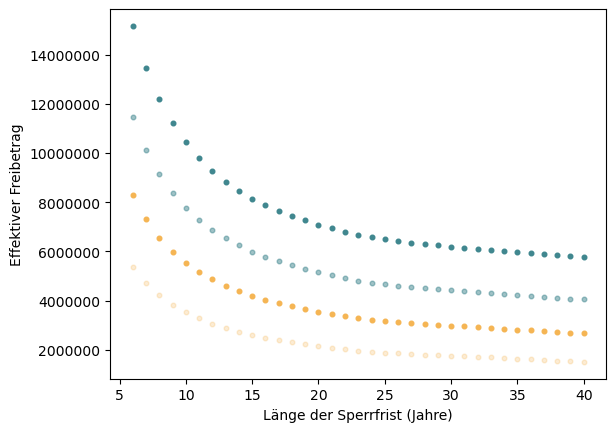

In [53]:
x = []
for i in range(5, 40):
    x.append(i + 1)
y50w74 = []
y50w64 = []
y50w52 = []
y50w35 = []
for i in x:
    y50w74.append(present_value_female(50, i, 400000, 0, 0.074))
    y50w64.append(present_value_female(50, i, 400000, 0, 0.064))
    y50w52.append(present_value_female(50, i, 400000, 0, 0.052))
    y50w35.append(present_value_female(50, i, 400000, 0, 0.035))
plt.xlabel("Länge der Sperrfrist (Jahre)")
plt.ylabel("Effektiver Freibetrag")
plt.scatter(x, y50w74, s=11, c=[[0.25, 0.53, 0.56, 1]])
plt.scatter(x, y50w64, s=11, c=[[0.25, 0.53, 0.56, 0.5]])
plt.scatter(x, y50w52, s=11, c=[[0.96, 0.71, 0.33, 1]])
plt.scatter(x, y50w35, s=11, c=[[0.96, 0.71, 0.33, 0.25]])
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
#plt.show()
plt.savefig(os.path.join('3_output', 'figure3_alternative.svg'), format = 'svg', dpi=300)

### Einfluss des Alters (für TRR266-Report)

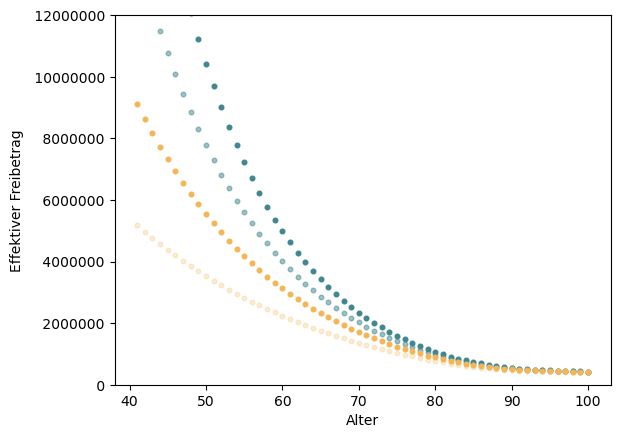

In [54]:
x = []
for i in range(40, 100):
    x.append(i + 1)
w74 = []
w64 = []
w52 = []
w35 = []
for i in x:
    w74.append(present_value_female(i, 10, 400000, 0, 0.074))
    w64.append(present_value_female(i, 10, 400000, 0, 0.064))
    w52.append(present_value_female(i, 10, 400000, 0, 0.052))
    w35.append(present_value_female(i, 10, 400000, 0, 0.035))
plt.xlabel("Alter")
plt.ylabel("Effektiver Freibetrag")
plt.scatter(x, w74, s=11, c=[[0.25, 0.53, 0.56, 1]])
plt.scatter(x, w64, s=11, c=[[0.25, 0.53, 0.56, 0.5]])
plt.scatter(x, w52, s=11, c=[[0.96, 0.71, 0.33, 1]])
plt.scatter(x, w35, s=11, c=[[0.96, 0.71, 0.33, 0.25]])
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x: .0f}'))
plt.ylim([0, 12000000])
#plt.show()
plt.savefig(os.path.join('3_output', 'figure1.svg'), format = 'svg', dpi=300)

### Verteilung Lebensalter Frauen Ost vs. West

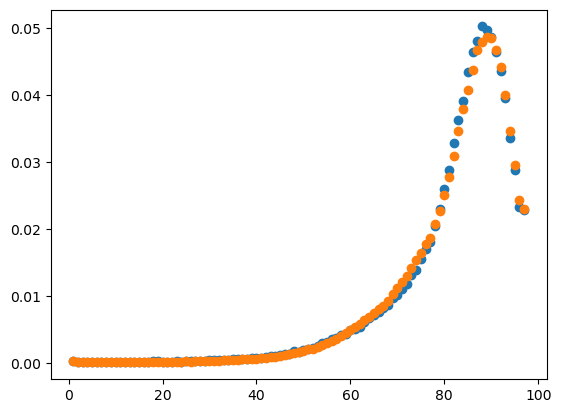

In [55]:
x = []
for i in range(0, 97):
    x.append(i + 1)
y_ossi = []
for i in x:
    y_ossi.append(death_prob_ossi_female(0, i))
y_wessi = []
for i in x:
    y_wessi.append(death_prob_wessi_female(0, i))
plt.scatter(x, y_ossi)
plt.scatter(x, y_wessi)
plt.show()

### Verteilung Lebensalter Männer Ost vs. West

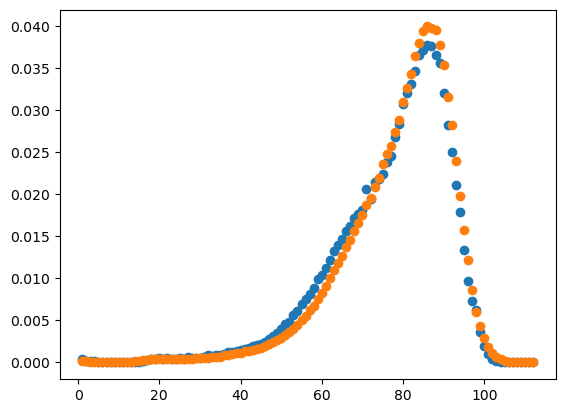

In [56]:
x = []
for i in range(0, 112):
    x.append(i + 1)
y_ossi = []
for i in x:
    y_ossi.append(death_prob_ossi_male(0, i))
y_wessi = []
for i in x:
    y_wessi.append(death_prob_wessi_male(0, i))
plt.scatter(x, y_ossi)
plt.scatter(x, y_wessi)
plt.show()

### Verteilung Lebensalter Männer gesamt vs. Frauen gesamt

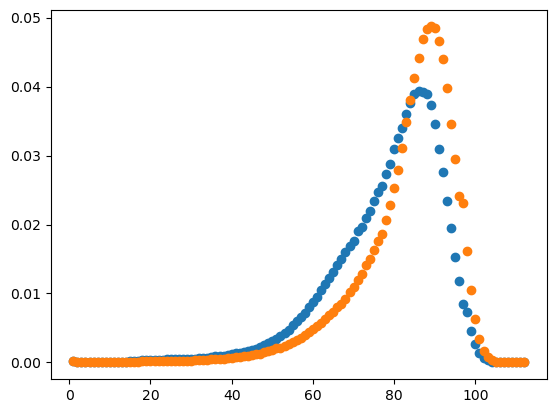

In [57]:
x = []
for i in range(0, 112):
    x.append(i + 1)
y_male = []
for i in x:
    y_male.append(death_prob_male(0, i))
y_female = []
for i in x:
    y_female.append(death_prob_female(0, i))
plt.scatter(x, y_male)
plt.scatter(x, y_female)
plt.show()

# Beispielswerte im Paper

### Einleitung

In [58]:
round(present_value_female(50,10, 400000, 0, 0.035))

3530383

### IV.1.

Männer

In [59]:
round(present_value_male(50, 10, 400000, 0, 0.035))

2951039

In [60]:
round(present_value_male(50, 10, 400000, 0, 0.074))

7990165

In [61]:
round(present_value_male(50, 10, 400000, 0, 0.074) - present_value_male(50, 10, 400000, 0, 0.035))

5039126

In [62]:
round(present_value_male(70, 10, 400000, 0, 0.035))

1148348

In [63]:
round(present_value_male(70, 10, 400000, 0, 0.074) - present_value_male(70, 10, 400000, 0, 0.035))

723626

Frauen

In [64]:
round(present_value_female(50, 10, 400000, 0, 0.035))

3530383

In [65]:
round(present_value_female(50, 10, 400000, 0, 0.035) - present_value_male(50, 10, 400000, 0, 0.035))

579344

In [66]:
round(present_value_female(70, 10, 400000, 0, 0.035) - present_value_male(70, 10, 400000, 0, 0.035))

208519

### IV.2.

Verzögerung um 1 Jahr

In [67]:
round(present_value_delay_male(50, 10, 400000, 0, 0.035, 0) - present_value_delay_male(50, 10, 400000, 0, 0.035, 1))

137655

In [68]:
round(present_value_delay_male(50, 10, 400000, 0, 0.074, 0) - present_value_delay_male(50, 10, 400000, 0, 0.074, 1))

586972

In [69]:
round(present_value_delay_male(70, 10, 400000, 0, 0.035, 0) - present_value_delay_male(70, 10, 400000, 0, 0.035, 1))

72162

In [70]:
round(present_value_delay_male(70, 10, 400000, 0, 0.074, 0) - present_value_delay_male(70, 10, 400000, 0, 0.074, 1))

160773

Verzögerung um 5 Jahre

In [71]:
round(present_value_delay_male(50, 10, 400000, 0, 0.035, 0) - present_value_delay_male(50, 10, 400000, 0, 0.035, 5))

639567

In [72]:
round(present_value_delay_male(50, 10, 400000, 0, 0.074, 0) - present_value_delay_male(50, 10, 400000, 0, 0.074, 5))

2553371

In [73]:
round(present_value_delay_male(70, 10, 400000, 0, 0.035, 0) - present_value_delay_male(70, 10, 400000, 0, 0.035, 5))

320383

In [74]:
round(present_value_delay_male(70, 10, 400000, 0, 0.074, 0) - present_value_delay_male(70, 10, 400000, 0, 0.074, 5))

681367

Approx. Steuerzahlungen

In [75]:
round(0.3 *( present_value_delay_male(50, 10, 400000, 0, 0.035, 0) - present_value_delay_male(50, 10, 400000, 0, 0.035, 5)))

191870

In [76]:
round( 0.3 * ( present_value_delay_male(50, 10, 400000, 0, 0.074, 0) - present_value_delay_male(50, 10, 400000, 0, 0.074, 5)))

766011

### Zusammenfassung

In [77]:
round(present_value_delay_male(50, 10, 400000, 0, 0.035, 0))

2951039

In [78]:
round(0.3 * present_value_delay_male(50, 10, 400000, 0, 0.035, 0))

885312

In [79]:
round(present_value_delay_female(50, 10, 400000, 0, 0.035, 0))

3530383

In [80]:
round(0.3 * present_value_delay_female(50, 10, 400000, 0, 0.035, 0))

1059115

In [81]:
round(present_value_delay_male(70, 10, 400000, 0, 0.035, 0) - present_value_delay_male(70, 10, 400000, 0, 0.035, 5))

320383